In [26]:
import torch
from torch import nn
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from main import DataDir
from main import File
import tqdm
from scipy.signal import savgol_filter

In [27]:
DIRECTORY_PATH = "/largedisk/julius_w/Development/conc2RDF/training_data"
new_dataset = DataDir(DIRECTORY_PATH)
new_dataset.get_relevant_files()
new_dataset.extract_data()
DEBUG_MODE = False

In [28]:
class NeuralNetwork(nn.Module):
    """Neural network that contains all the parameters."""

    device = "cuda" if torch.cuda.is_available() else "cpu"
    loss_fn = nn.MSELoss()
    epochs = 2000

    def __init__(self, dataset: DataDir) -> None:
        """Create vanilla NN."""
        super().__init__()
        self.dataset = dataset
        self.losses = []
        self.validations_losses = []
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 64),
            # with 512 for all hidden layers loss and val_loss oscillate after some time
            nn.ReLU(),
            nn.Linear(64, 64),
            # 512 instead of 64, lower learning rate no oscillation but no better result
            nn.ReLU(),
            nn.Linear(64, dataset.num_points),
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.to(self.device)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        """Perform forward propagation."""
        return self.linear_relu_stack(x)


    def train_step(self, train_set : list) -> float:
        """"Train the NN on a small sample of training data."""
        self.train()
        loss_value = 0
        for i in train_set:
            x_data = torch.tensor([self.dataset.data[i, 0]]).to(NeuralNetwork.device)
            y_data = self.dataset.data[i, 1:].to(NeuralNetwork.device)
            pred = self(x_data)
            loss = NeuralNetwork.loss_fn(pred, y_data)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            loss_value += loss.item()
        loss_value = loss_value / len(train_set)
        if DEBUG_MODE:
            print(f"loss: {loss_value:>7f}")
        return loss_value

    def test_step(self, test_set: list) -> float:
        """Compare prediction with real test-data."""
        self.eval()
        test_loss = 0
        with torch.no_grad():
            for i in test_set:
                x = torch.tensor([self.dataset.data[i, 0]]).to(NeuralNetwork.device)
                y = self.dataset.data[i, 1:].to(NeuralNetwork.device)
                pred = self(x)
                test_loss += NeuralNetwork.loss_fn(pred, y).item()
        test_loss /= len(test_set)
        return test_loss

    def train_test_loop(self, train_set: list, test_set: list):
        for t in tqdm(range(NeuralNetwork.epochs)):
            if DEBUG_MODE:
                print(f"Epoch {t+1}\n -----------------------")
            avg_loss = self.train_step(train_set)
            self.losses.append(avg_loss)
            val_loss = self.test_step(test_set)
            self.validations_losses.append(val_loss)

    def get_dashboard(self):
        fig, axs = plt.subplots(2, 1)
        axs[0].plot(self.losses, "o", ms=3, label="trainig")
        axs[1].plot(self.validations_losses, "o", ms=3, label="testing")
        axs[0].semilogy()
        axs[1].semilogy()
        axs[0].legend()
        axs[1].legend()
        plt.show()

    def save_model(self):
        torch.save(self, "model.pth")

In [29]:
model = torch.load("model.pth", weights_only=False)

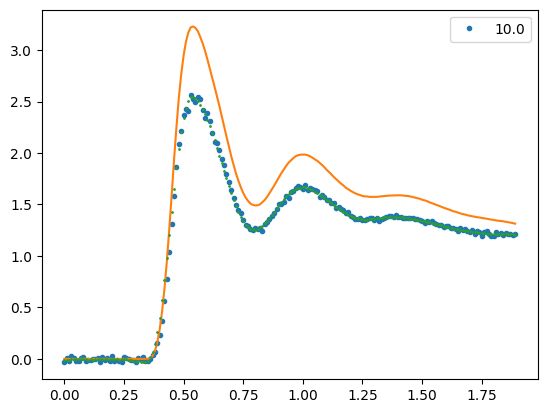

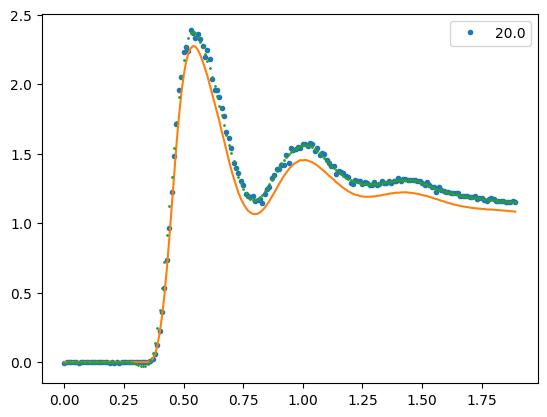

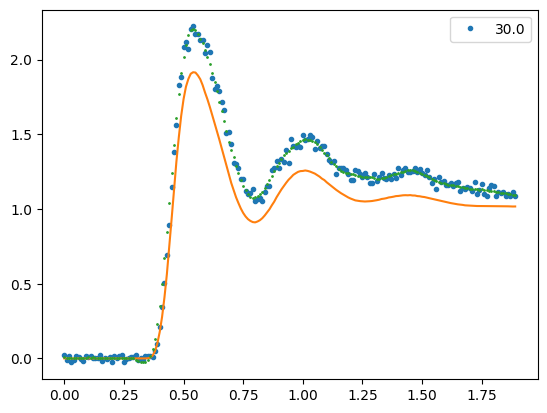

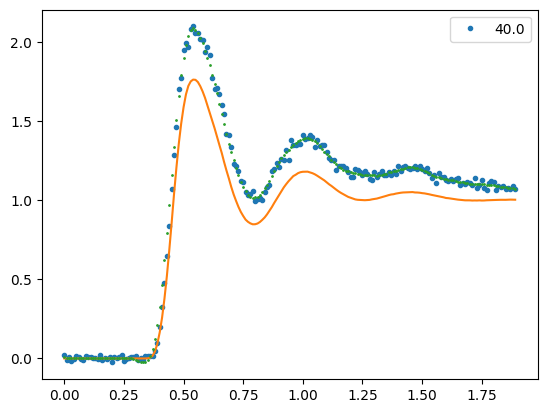

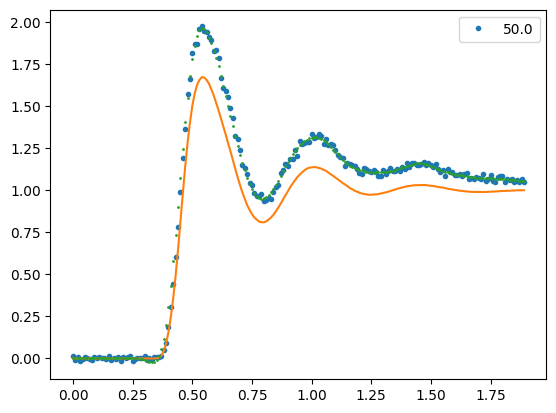

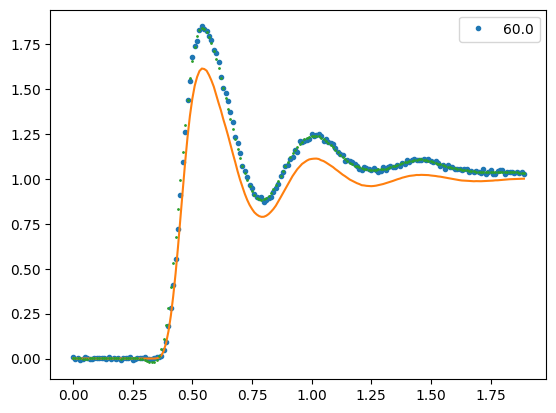

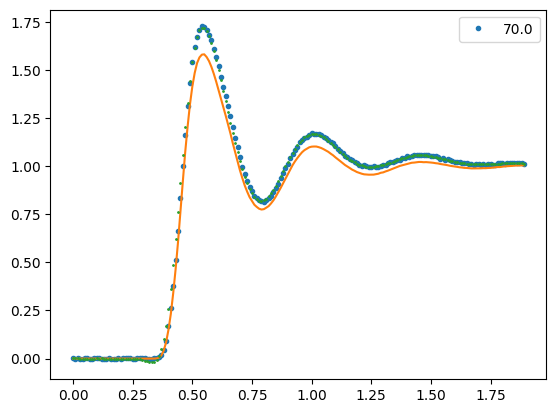

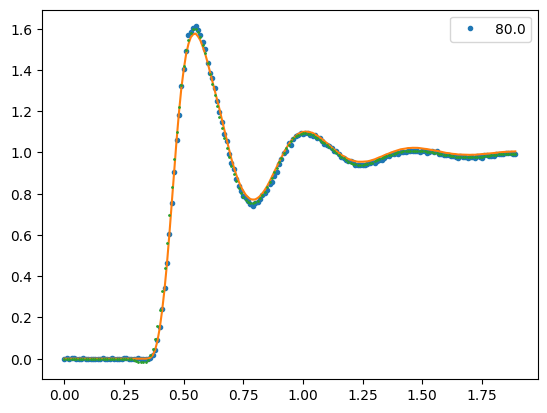

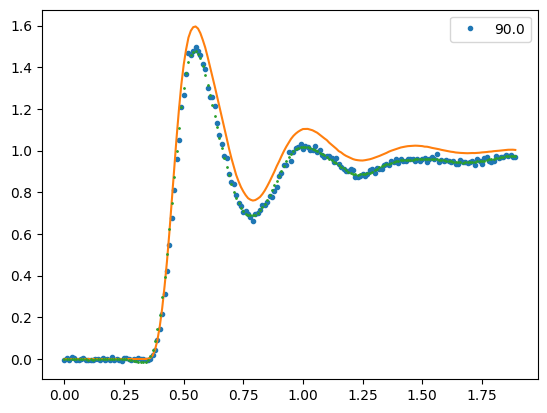

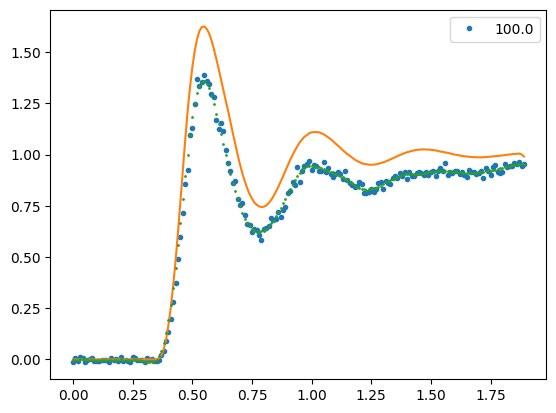

In [30]:
model.eval()
with torch.no_grad():
    for i in range(10):
        X = torch.tensor([new_dataset.data[i, 0]]).to("cuda")
        pred = model(X).cpu()
        smooth_predidction = savgol_filter(pred, window_length=20, polyorder=3)
        plt.plot(new_dataset.r_values, pred, "o", ms=3, label=f"{X.item()}")
        plt.plot(new_dataset.r_values, new_dataset.data[i, 1:])
        plt.plot(new_dataset.r_values, smooth_predidction, "o", ms=1)
        plt.legend()
        plt.show()